# Introductory Example

This notebook details a time series analysis and forecasting application performed with scalecast using the daily visitors dataset. The following concepts are covered:  

1. Exploratory Data Analysis  
2. Exponential Smoothing (usng Holt-Winters)  
3. ARIMA  
4. Multiple Linear Regression for forecasting  
5. Scikit-learn models and hyperparameter tuning  
6. Multivariate forecasting with scikit-learn models  
7. Facebook Prophet  
8. LinkedIn Greykite/Silverkite  
9. TensorFlow recurrent neural nets  
10. Native combination modeling   

The utilized dataset is available on [Kaggle](https://www.kaggle.com/datasets/bobnau/daily-website-visitors) or [RegressIt](https://regressit.com/data.html).  

## Library Imports
First, let's import the libraries and read the data. Some data preprocessing in pandas will be necessary before calling scalecast.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast import GridGenerator
from scalecast.notebook import tune_test_forecast

In [2]:
# read in data
data = pd.read_csv('daily-website-visitors.csv',parse_dates = ['Date'], thousands=',')

In [3]:
# set graph sizes
sns.set(rc={'figure.figsize':(12,8)})

## Exploratory Data Analysis

Let's view the data's first five rows.

In [4]:
data.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,2014-09-14,2146,1582,1430,152
1,2,Monday,2,2014-09-15,3621,2528,2297,231
2,3,Tuesday,3,2014-09-16,3698,2630,2352,278
3,4,Wednesday,4,2014-09-17,3667,2614,2327,287
4,5,Thursday,5,2014-09-18,3316,2366,2130,236


Make sure the dataset is in sequential order:

In [5]:
data = data.sort_values('Date')

A little about the series in the dataset:

In [6]:
data.drop(['Row'],axis=1).describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Day,2167,7,Sunday,310,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Day.Of.Week,2167.0,NaN,NaN,NaN,NaT,NaT,3.997231,2.000229,1.0,2.0,4.0,6.0,7.0
Date,2167,2167,2014-09-14 00:00:00,1,2014-09-14,2020-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Page.Loads,2167.0,NaN,NaN,NaN,NaT,NaT,4116.989386,1350.977843,1002.0,3114.5,4106.0,5020.5,7984.0
Unique.Visits,2167.0,NaN,NaN,NaN,NaT,NaT,2943.646516,977.886472,667.0,2226.0,2914.0,3667.5,5541.0
First.Time.Visits,2167.0,NaN,NaN,NaN,NaT,NaT,2431.824181,828.704688,522.0,1830.0,2400.0,3038.0,4616.0
Returning.Visits,2167.0,NaN,NaN,NaN,NaT,NaT,511.822335,168.73637,133.0,388.5,509.0,626.5,1036.0


Let's load the series we want to predict, Unique Visits, into a `Forecaster` object:

In [7]:
f = Forecaster(y=data['Unique.Visits'],current_dates=data['Date'])
f

Forecaster(
    DateStartActuals=2014-09-14T00:00:00.000000000
    DateEndActuals=2020-08-19T00:00:00.000000000
    Freq=D
    N_actuals=2167
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

This shows we have 2,167 daily observations from 9/14/2014 through 8/19/2020 to forecast with.

The first thing we should do after initializing the object is set its test length. We can choose a number of observations to use by passing an `int` to the function below, or split the data fractionally by passing a `float` between 0 and 1.

In [8]:
f.set_test_length(.2)

Before beginning the forecasting process, we should get a better idea of the signals within the time series itself. Using ACF, PACF, and Periodogram plots, we can observe how the series is auto-correlated. We can leave the test set out of all visualizations (`train_only=True`) to not leak data when making decisions about which signals exist in the data.

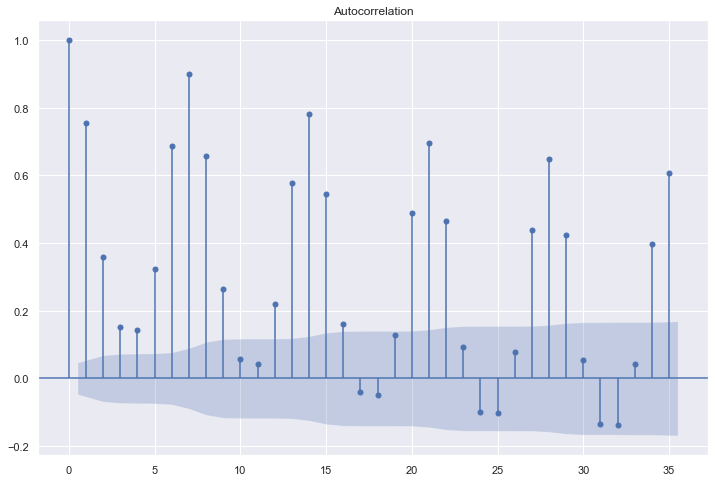

In [9]:
f.plot_acf(train_only=True,lags=35)
plt.show()

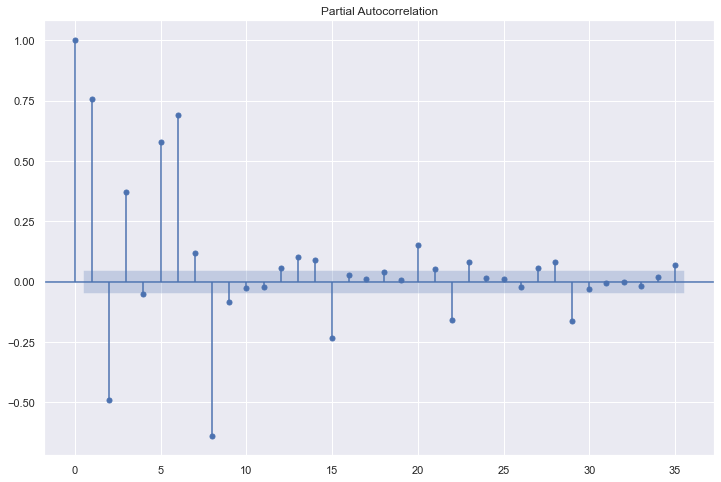

In [10]:
f.plot_pacf(train_only=True,lags=35)
plt.show()

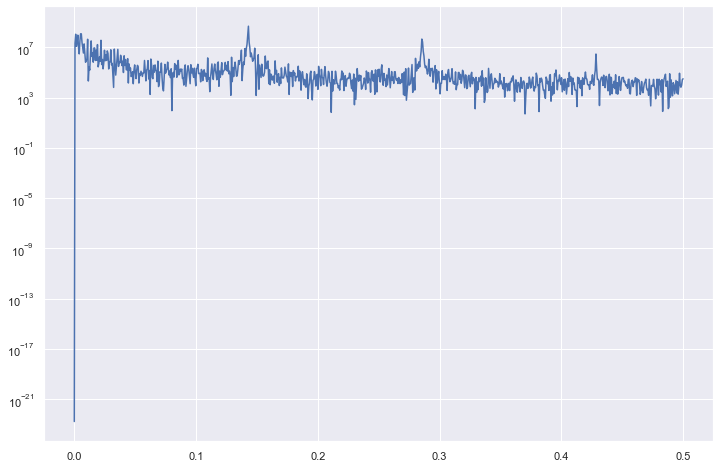

In [11]:
a, b = f.plot_periodogram(train_only=True)
plt.semilogy(a, b)
plt.show()

There might be some drift in the data.

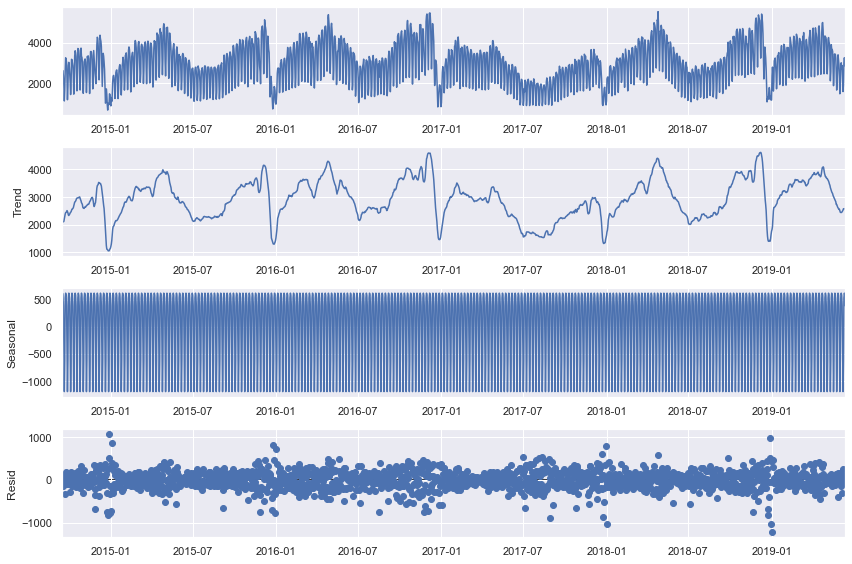

In [12]:
f.seasonal_decompose(train_only=True).plot()
plt.show()

From these graphs, we get a sense that the data exhibits several seasonalities, including possibly daily, weekly, monthly, and quarterly. There may be a trend in the data as well and there is definitely autoregression (the series past correlates with its future).  We can use these observations to make decisions about how to model the dataset. First, however, let's test its stationarity with an augmented dickey-fuller test. It's generally better to always model with stationary data, although it doesn't matter as much for some models.

In [13]:
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: -4.48
the p-value is 0.0002
the series is stationary
----------------------------------------------------------------------------------------------------


In [14]:
GridGenerator.get_example_grids()
GridGenerator.get_mv_grids()

These functions save a Grids.py and MVGrids.py file to the working directory. The grids in these files will automatically be read for each model class unless we pass our own grid manually.

Let's now incorporate our observations from EDA as decisions in our `Forecaster` object:

In [15]:
f.generate_future_dates(60) # forecast horizon
f.set_validation_length(60) # validation slice of data length (if tuning w/o cross validation)
f.add_ar_terms(7) # 7 dep variable lags
f.add_AR_terms((5,7)) # 5 weekly seasonaly dep variable lags
f.add_seasonal_regressors(
    'month',
    'quarter',
    'week',
    'dayofyear',
    raw=False,
    sincos=True) # wave-form seasonality
f.add_seasonal_regressors(
    'dayofweek',
    'week',
    raw=False,
    dummy=True,
    drop_first=True
) # dummy variable seasonality
f.add_seasonal_regressors('year') # yearly trend

We've added a lot of regressors, but we can reduce them using a permutated feature scoring method, described in this [article](https://towardsdatascience.com/variable-reduction-techniques-for-time-series-646743f726d4) and in the [docs](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.reduce_Xvars).

In [16]:
f.reduce_Xvars(
    method='pfi',
    estimator='mlr',
    cross_validate=True,
    cvkwargs={'k':3},
    keep_at_least='sqrt',
)

In [17]:
f

Forecaster(
    DateStartActuals=2014-09-14T00:00:00.000000000
    DateEndActuals=2020-08-19T00:00:00.000000000
    Freq=D
    N_actuals=2167
    ForecastLength=60
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR14', 'AR28', 'AR35', 'monthsin', 'monthcos', 'quartercos', 'weeksin', 'weekcos', 'dayofyearsin', 'dayofyearcos', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'week_16', 'week_17', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_39', 'week_4', 'week_40', 'week_41', 'week_42', 'week_43', 'week_49', 'week_5', 'week_51', 'week_52', 'week_53', 'week_6', 'week_8']
    Differenced=0
    TestLength=433
    ValidationLength=60
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

## Selecting which models to forecast with
The following estimators are available to us:  

1. ARIMA  
2. prophet  
3. silverkite  
4. Sklearn univariate  
5. Combo  
6. Sklearn multivariate  
7. RNN  
8. LSTM  
9. HWES  
10. Theta  

We will briefly review each one in this order. The models that can be tuned using grid searches, we will tune. For some of these, we will use our own grids, but there are default grids from scalecast itself that we could also use. Let's get those grids.

### ARIMA

- Linear estimator speciablized for time series  
- Can be tuned with a grid search  
- By default, we can pass weekly seasonality to it but also pass other seasonality in the form of external regressors    
- Dig deeper into ARIMA with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/arima/arima.html)  

In [18]:
f.set_estimator('arima')
arima_grid = {
    'order':[
        (1,0,1),
        (1,0,0),
        (0,0,1)
    ],
    'seasonal_order':[
        (1,0,1,7),
        (1,0,0,7),
        (0,0,1,7),
        (0,1,0,7)
    ],
    'Xvars':[
        None,
        [
            'monthsin',
            'monthcos',
            'weeksin',
            'weekcos',
            'dayofyearsin',
            'dayofyearcos'
        ]
    ],
}

You may want to try larger grids than that in real life. By default, all grid combos will be tried, but [randomized grid-search](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.limit_grid_size) is also available. If this weren't just an example, it would probably be smart to add more orders to the grid. Or, not use ARIMA at all for a dataset like this.

In [19]:
f.ingest_grid(arima_grid)
f.tune() 

To automatically take the best parameters chosen in the tuning process:

In [20]:
f.auto_forecast()

Test-set results:

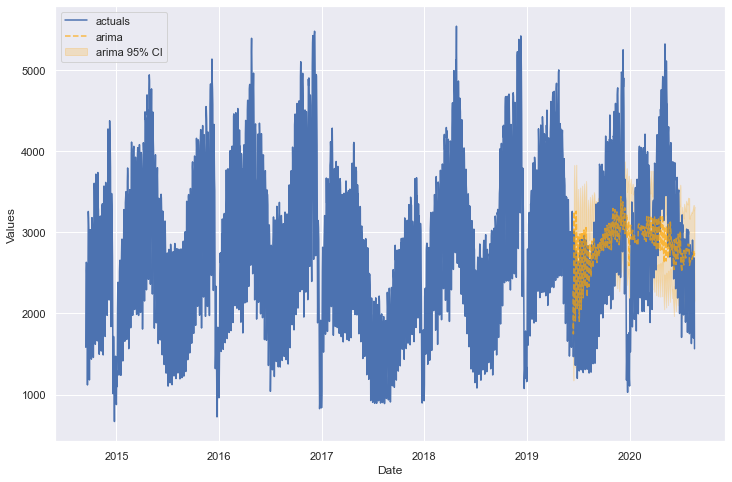

In [21]:
f.plot_test_set(ci=True,models='arima')
plt.show()

ARIMA was able to capture the general direction of the series at different steps, but it isn't capturing all the series' seasonal components very well. Typically, ARIMA doesn't perform well on a series with more than one kind of stationarity.

If we want to see the results of the tuning process:

In [22]:
f.export_validation_grid('arima').sort_values('metric_value').head()

,order,seasonal_order,Xvars,validation_length,validation_metric,metric_value
19,"(0, 0, 1)","(1, 0, 0, 7)","[monthsin, monthcos, weeksin, weekcos, dayofye...",60,rmse,461.053191
17,"(0, 0, 1)","(1, 0, 1, 7)","[monthsin, monthcos, weeksin, weekcos, dayofye...",60,rmse,475.732122
3,"(1, 0, 1)","(1, 0, 0, 7)","[monthsin, monthcos, weeksin, weekcos, dayofye...",60,rmse,505.891372
7,"(1, 0, 1)","(0, 1, 0, 7)","[monthsin, monthcos, weeksin, weekcos, dayofye...",60,rmse,547.954248
23,"(0, 0, 1)","(0, 1, 0, 7)","[monthsin, monthcos, weeksin, weekcos, dayofye...",60,rmse,578.434064


Model summary for ARIMA:

In [23]:
f.save_summary_stats()
f.export_summary_stats('arima')

,coef,std err,z,P>|z|,[0.025,0.975]
const,2890.0261,97.058,29.776,0.000,2699.795,3080.257
x1,606.0906,64.026,9.466,0.000,480.602,731.579
x2,-105.2415,81.098,-1.298,0.194,-264.192,53.709
x3,-3208.5402,483.600,-6.635,0.000,-4156.378,-2260.702
x4,-3244.5797,1388.712,-2.336,0.019,-5966.404,-522.755
x5,2575.5383,501.546,5.135,0.000,1592.526,3558.550
x6,3406.5461,1400.264,2.433,0.015,662.079,6151.013
ma.L1,0.6384,0.015,42.084,0.000,0.609,0.668
ar.S.L7,0.8786,0.011,83.624,0.000,0.858,0.899
sigma2,96150.0000,2252.962,42.676,0.000,91700.000,101000.000


### Prophet
- Prophet is an automated forecasting procedure developed by Facebook  
- It uses the following components to predict the series in linear model:  
  - Trend  
  - Holiday effects  
  - Seasonality  
- It is capable of capturing many different kinds of seasonality  
- It attempts to identify changepoints in the series to handle non-stationary data  
- This model can be tuned in scalecast, but we will bypass that because it does a lot of tuning on itself  
- Dig deeper into Prophet with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/prophet/prophet.html)  

In [24]:
f.set_estimator('prophet')
f.manual_forecast()

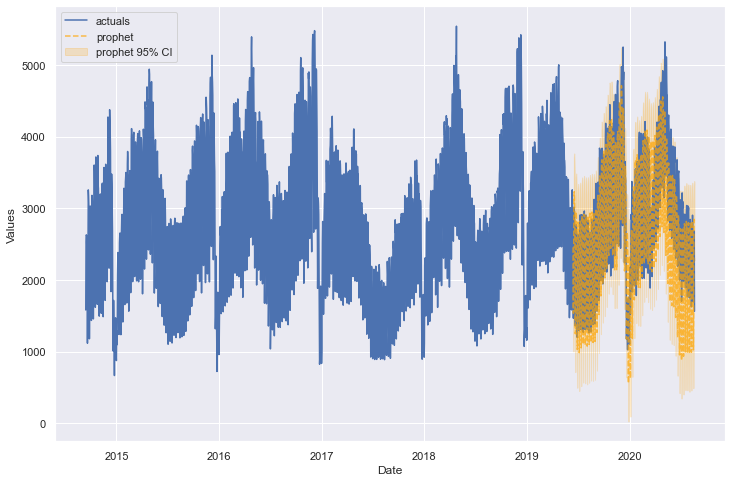

In [25]:
f.plot_test_set(ci=True,models='prophet')
plt.show()

This looks much better than ARIMA.

### Silverkite
- Silverkite is an automated forecasting procedure developed by LinkedIn and found in the [greykite](https://linkedin.github.io/greykite/) package  
- It uses the following components to predict the series:  
  - Trend  
  - Holiday effects  
  - Seasonality
  - AR components
- It is capable of capturing many different kinds of seasonality  
- It attempts to identify changepoints in the series to handle non-stationary data  
- This model can be tuned in scalecast, but we will bypass that because it does a lot of tuning on itself  
- Dig deeper into Silverkite with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/silverkiet/silverkiet.html)  

In [26]:
f.set_estimator('silverkite')
f.manual_forecast()

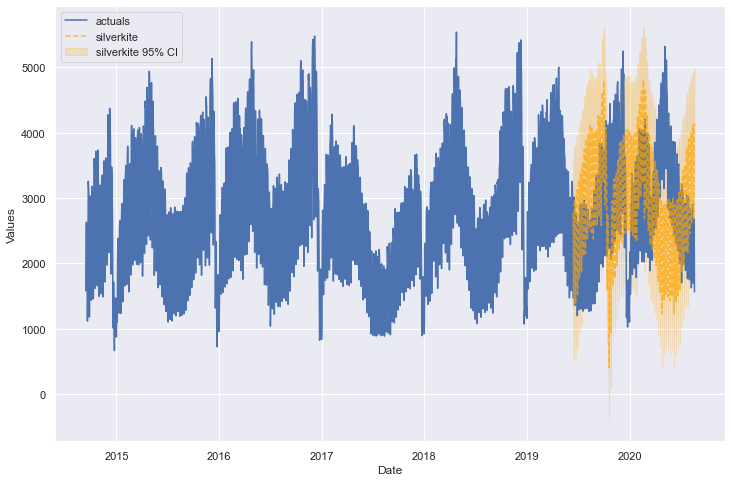

In [27]:
f.plot_test_set(ci=True,models='silverkite')
plt.show()

This does not look as good as prophet, but possibly better than ARIMA.

### Sklearn univariate
- Dig deeper into Sklearn estimators with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/sklearn/sklearn.html)

#### MLR
- `dynamic_testing=60` creates a rolling dynamic evaluation on the test set of 60 periods. It is only available with sklearn and multivariate regressors for now.

In [31]:
f.set_estimator('mlr')
f.manual_forecast(dynamic_testing=60)
f.save_feature_importance()

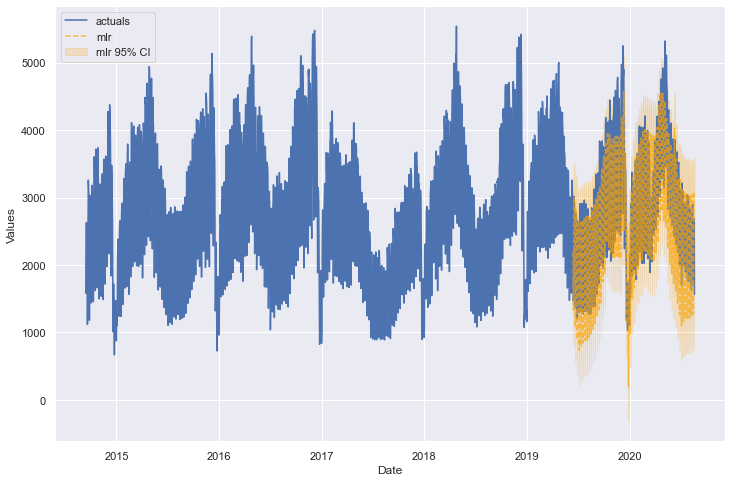

In [32]:
f.plot_test_set(ci=True,models='mlr')
plt.show()

MLR is a linear estimator, like ARIMA, but it makes better predictions on this dataset since it can more readily model multiple seasonalities.

#### XGBoost
- this time, to tune the model, we can use cross validation instead of a validation slice of data (like we did with arima)
- we pass 60 to the `dynamic_tuning` argument so that we can find the model hyperparams that are best at predicting 60 periods into the future, which is our forecast horizon length.

In [33]:
f.set_estimator('xgboost')
xgboost_grid = {
     'n_estimators':[150,200,250],
     'scale_pos_weight':[5,10],
     'learning_rate':[0.1,0.2],
     'gamma':[0,3,5], 
     'subsample':[0.8,0.9]
}
f.ingest_grid(xgboost_grid)
f.cross_validate(k=3,dynamic_tuning=60) # 3 fold cv
f.auto_forecast(dynamic_testing=60)

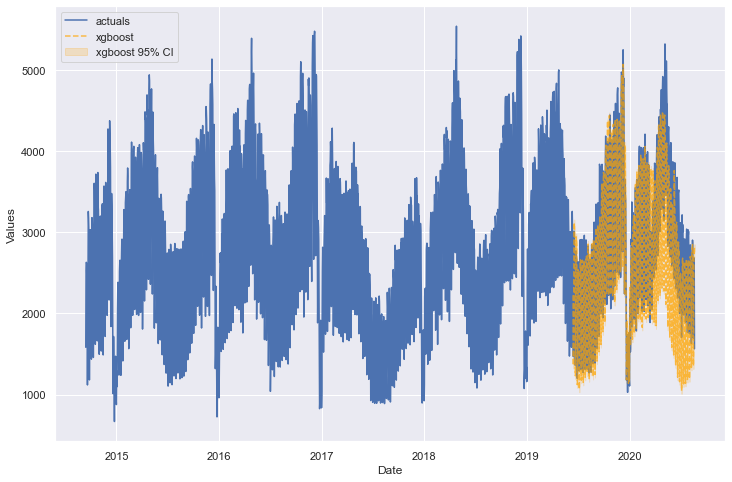

In [34]:
f.plot_test_set(ci=True,models='xgboost')
plt.show()

### Combo  
- Dig deeper into combo estimators with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/combo/combo.html)

In [35]:
f.set_estimator('combo')
f.manual_forecast(how='simple',models='all',determine_best_by='TestSetMAPE',call_me='avg')

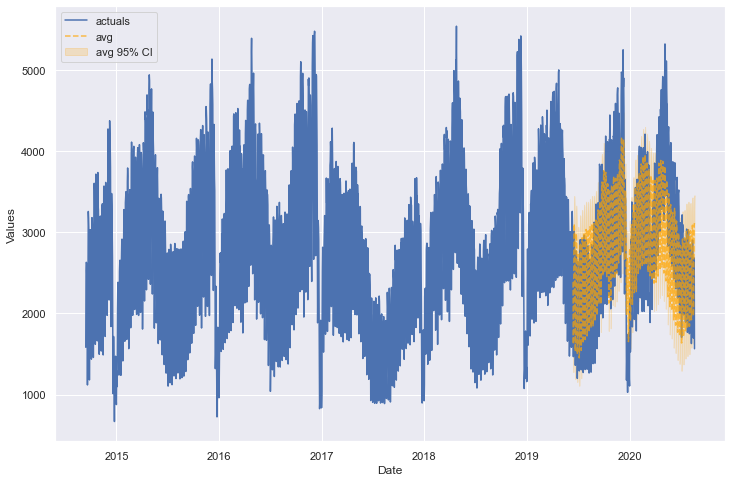

In [36]:
f.plot_test_set(ci=True,models='avg')
plt.show()

In [37]:
results = f.export('model_summaries',determine_best_by='TestSetMAPE')
results.columns

Index(['ModelNickname', 'Estimator', 'Xvars', 'HyperParams', 'Scaler',
       'Observations', 'Tuned', 'CrossValidated', 'DynamicallyTested',
       'Integration', 'TestSetLength', 'TestSetRMSE', 'TestSetMAPE',
       'TestSetMAE', 'TestSetR2', 'LastTestSetPrediction', 'LastTestSetActual',
       'CILevel', 'CIPlusMinus', 'InSampleRMSE', 'InSampleMAPE', 'InSampleMAE',
       'InSampleR2', 'ValidationSetLength', 'ValidationMetric',
       'ValidationMetricValue', 'models', 'weights', 'LevelTestSetRMSE',
       'LevelTestSetMAPE', 'LevelTestSetMAE', 'LevelTestSetR2', 'best_model'],
      dtype='object')

In [38]:
results[['ModelNickname','TestSetMAPE','TestSetR2','InSampleMAPE','InSampleR2','best_model']]

,ModelNickname,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2,best_model
0,xgboost,0.114121,0.758769,0.005687,0.999593,True
1,mlr,0.119815,0.800517,0.061176,0.954452,False
2,prophet,0.128508,0.756013,0.098131,0.887426,False
3,avg,0.146941,0.675437,0.057269,0.960752,False
4,arima,0.248641,0.158171,0.090015,0.898082,False
5,silverkite,0.383909,-0.711844,0.119990,0.839140,False


### Sklearn Multivariate  
- This is a method to forecast several series together, using each other's lags as inputs  
- You can use several lags from one and fewer with others, non-sequential lags, and more with this approach  
- Dig deeper into multivariate forecasting with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/multivariate/multivariate.html)  
- See the [docs](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html)

#### Prepare

In [39]:
f_dict = {c: Forecaster(
    y=data[c],
    current_dates=data['Date'],
) for c in ('Page.Loads','First.Time.Visits')}
f_dict['Unique.Visits'] = f.copy()
# combine all series into one object
mvf = MVForecaster(*f_dict.values(),names=f_dict.keys())
# set test length
mvf.set_test_length(.2) 

Even though we are now forecasting three series together, we might still want to optimize our models based on which one best predicts unique visits. This means that in the tuning process, model hyperparameters will be selected based on which combination predicts this sereis this bset.

In [40]:
mvf.set_optimize_on('Unique.Visits')

By default, models are optimized based on the average error or accuracy metrics across all series. But in the above method, we can add our own weighted average or choose one series to consider above the others. See the docs [here](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.set_optimize_on) and [here](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.add_optimizer_func).

In [41]:
mvf

MVForecaster(
    DateStartActuals=2014-09-14T00:00:00.000000000
    DateEndActuals=2020-08-19T00:00:00.000000000
    Freq=D
    N_actuals=2167
    N_series=3
    SeriesNames=['Page.Loads', 'First.Time.Visits', 'Unique.Visits']
    ForecastLength=60
    Xvars=['monthsin', 'monthcos', 'quartercos', 'weeksin', 'weekcos', 'dayofyearsin', 'dayofyearcos', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'week_16', 'week_17', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_39', 'week_4', 'week_40', 'week_41', 'week_42', 'week_43', 'week_49', 'week_5', 'week_51', 'week_52', 'week_53', 'week_6', 'week_8']
    TestLength=433
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=mlr
    OptimizeOn=Unique.Visits
)

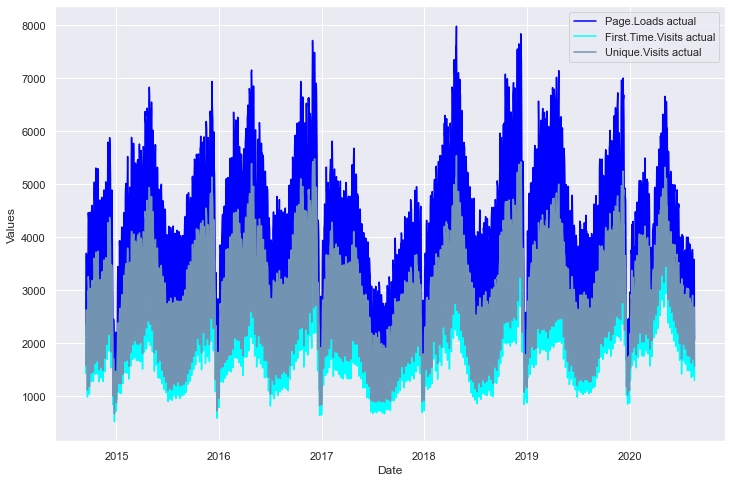

In [42]:
mvf.plot()
plt.show()

#### MLR

In [43]:
mvf.set_estimator('mlr')
mvf.manual_forecast(lags=7,dynamic_testing=60)

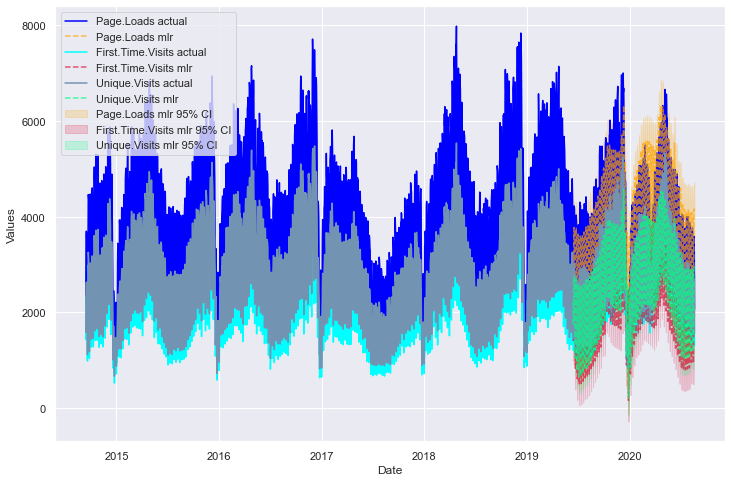

In [44]:
mvf.plot_test_set(ci=True)
plt.show()

#### XGBoost
- this time, when tuning xgboost, we use the optimal hyperparameters we found while doing univariate modeling and add a `'lags'` argument to a new grid. This is an argument that always must be specified in the `MVForecaster` object and by default it is 1.
- we can speed up processing by limiting grid search to 10 combinations

In [45]:
mvf.set_estimator('xgboost')
xgboost_mv_grid = {k:[v] for k, v in f.history['xgboost']['HyperParams'].items()}
xgboost_mv_grid['lags'] = np.arange(1,36,1)
mvf.ingest_grid(xgboost_mv_grid)
mvf.limit_grid_size(10,random_seed=20)
mvf.cross_validate(k=3,dynamic_tuning=60)
mvf.auto_forecast(dynamic_testing=60)

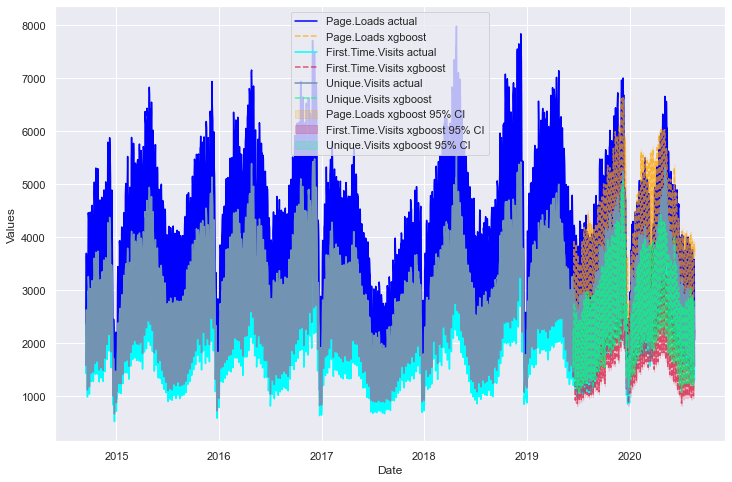

In [46]:
mvf.plot_test_set(ci=True,models='xgboost')
plt.show()

We can now tell the object to select the best model out of the xgboost and mlr based on whichever one achieved a better test MAPE value on the unique visitors series.

In [47]:
mvf.set_best_model(determine_best_by='TestSetMAPE')

Benchmark results.

In [48]:
mvresults = mvf.export_model_summaries()
mvresults.columns

Index(['Series', 'ModelNickname', 'Estimator', 'Xvars', 'HyperParams', 'Lags',
       'Scaler', 'Observations', 'Tuned', 'CrossValidated',
       'DynamicallyTested', 'Integration', 'TestSetLength', 'TestSetRMSE',
       'TestSetMAPE', 'TestSetMAE', 'TestSetR2', 'LastTestSetPrediction',
       'LastTestSetActual', 'CILevel', 'CIPlusMinus', 'InSampleRMSE',
       'InSampleMAPE', 'InSampleMAE', 'InSampleR2', 'ValidationSetLength',
       'ValidationMetric', 'ValidationMetricValue', 'LevelTestSetRMSE',
       'LevelTestSetMAPE', 'LevelTestSetMAE', 'LevelTestSetR2', 'OptimizedOn',
       'MetricOptimized', 'best_model'],
      dtype='object')

In [49]:
mvresults[['Series','ModelNickname','TestSetMAPE','TestSetR2','InSampleMAPE','InSampleR2','Lags','best_model']]

,Series,ModelNickname,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2,Lags,best_model
0,Page.Loads,mlr,0.134720,0.750073,0.064699,0.948422,7,True
1,Page.Loads,xgboost,0.114262,0.784981,0.007298,0.999306,5,False
2,First.Time.Visits,mlr,0.148908,0.726061,0.065452,0.951754,7,True
3,First.Time.Visits,xgboost,0.143720,0.707676,0.007702,0.999347,5,False
4,Unique.Visits,mlr,0.129015,0.776677,0.061485,0.954058,7,True
5,Unique.Visits,xgboost,0.129960,0.753377,0.006545,0.999462,5,False


In [50]:
mvf.export_validation_grid('xgboost').sort_values('optimized_metric').head()

,n_estimators,scale_pos_weight,learning_rate,gamma,subsample,lags,validation_length,validation_metric,Page.Loads_metric,First.Time.Visits_metric,Unique.Visits_metric,optimized_metric,fold,rolling,train_length
10,200,5,0.2,3,0.8,5,433,rmse,617.926305,379.079477,431.024898,431.024898,1,False,868
0,200,5,0.2,3,0.8,5,433,rmse,724.301567,375.837887,443.137179,443.137179,0,False,1301
20,200,5,0.2,3,0.8,5,433,rmse,559.238077,316.732464,447.642412,447.642412,2,False,435
28,200,5,0.2,3,0.8,2,433,rmse,572.282744,338.112421,458.908761,458.908761,2,False,435
29,200,5,0.2,3,0.8,6,433,rmse,619.715769,341.420155,475.286833,475.286833,2,False,435


### RNN  
- Recurrent Neural Networks are considered a state-of-the-art model for forecasting time series. In scalecast, a fairly high amount of customization from Keras TensforFlow is available, with SimpleRNN, LSTM, and Dense cells all easily able to be specified. You will get the most out of neural networks by using a library built to dynamically build these models, such as Pytorch, Keras TF, or Darts. The advantage of applying these models in scalecast is that they are easy to use, adjust, and quickly see results.  
- We will apply all these models test-only to speed up processing time  
- This model cannot be tuned and does not accept variables other than the series' own history to make predictions  
- Dig deeper into RNN forecasting with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/rnn/rnn.html) and [this notebook](https://scalecast-examples.readthedocs.io/en/latest/lstm/lstm.html)  

Epoch 1/150
31/31 [==============================] - 3s 43ms/step - loss: 0.3491 - val_loss: 0.2387
Epoch 2/150
31/31 [==============================] - 1s 36ms/step - loss: 0.1914 - val_loss: 0.1695
Epoch 3/150
31/31 [==============================] - 1s 39ms/step - loss: 0.1696 - val_loss: 0.1665
Epoch 4/150
31/31 [==============================] - 1s 33ms/step - loss: 0.1687 - val_loss: 0.1630
Epoch 5/150
31/31 [==============================] - 1s 32ms/step - loss: 0.1656 - val_loss: 0.1592
Epoch 6/150
31/31 [==============================] - 1s 32ms/step - loss: 0.1559 - val_loss: 0.1447
Epoch 7/150
31/31 [==============================] - 1s 35ms/step - loss: 0.1441 - val_loss: 0.1291
Epoch 8/150
31/31 [==============================] - 1s 33ms/step - loss: 0.1364 - val_loss: 0.1270
Epoch 9/150
31/31 [==============================] - 1s 32ms/step - loss: 0.1335 - val_loss: 0.1232
Epoch 10/150
31/31 [==============================] - 1s 33ms/step - loss: 0.1315 - val_loss: 0.1215

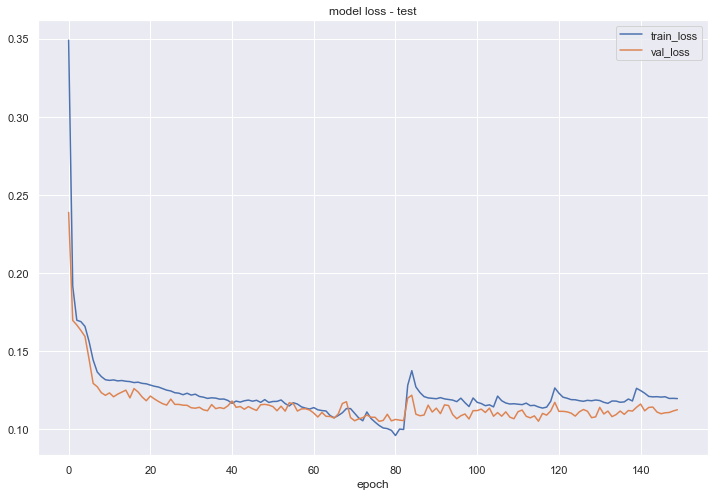

In [51]:
f.set_estimator('rnn')
f.manual_forecast(
    lags=75,
    layers_struct=[('SimpleRNN',{'units':100,'dropout':0})]*2 + [('Dense',{'units':10})]*2,
    epochs=150,
    random_seed=42,
    plot_loss_test=True,
    validation_split=0.2,
    call_me='rnn',
    verbose=1,
    test_only=True,
)

Epoch 1/75
31/31 [==============================] - 7s 120ms/step - loss: 0.3570 - val_loss: 0.2415
Epoch 2/75
31/31 [==============================] - 3s 96ms/step - loss: 0.1917 - val_loss: 0.1698
Epoch 3/75
31/31 [==============================] - 3s 103ms/step - loss: 0.1700 - val_loss: 0.1671
Epoch 4/75
31/31 [==============================] - 3s 90ms/step - loss: 0.1692 - val_loss: 0.1655
Epoch 5/75
31/31 [==============================] - 3s 90ms/step - loss: 0.1692 - val_loss: 0.1659
Epoch 6/75
31/31 [==============================] - 3s 90ms/step - loss: 0.1690 - val_loss: 0.1668
Epoch 7/75
31/31 [==============================] - 3s 97ms/step - loss: 0.1690 - val_loss: 0.1659
Epoch 8/75
31/31 [==============================] - 3s 89ms/step - loss: 0.1691 - val_loss: 0.1654
Epoch 9/75
31/31 [==============================] - 3s 90ms/step - loss: 0.1690 - val_loss: 0.1657
Epoch 10/75
31/31 [==============================] - 3s 91ms/step - loss: 0.1688 - val_loss: 0.1651
Epoch 1

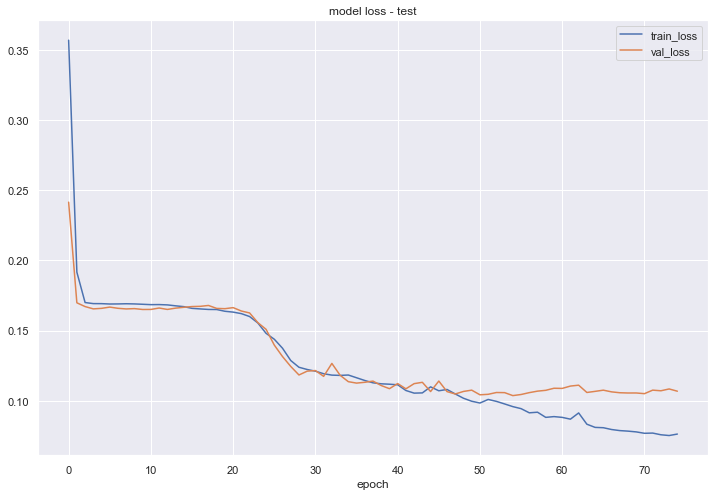

In [52]:
f.manual_forecast(
    lags=75,
    layers_struct=[('LSTM',{'units':100,'dropout':0})]*2 + [('Dense',{'units':10})]*2,
    epochs=75,
    random_seed=42,
    plot_loss_test=True,
    validation_split=0.2,
    call_me='lstm',
    verbose=1,
    test_only=True,
)

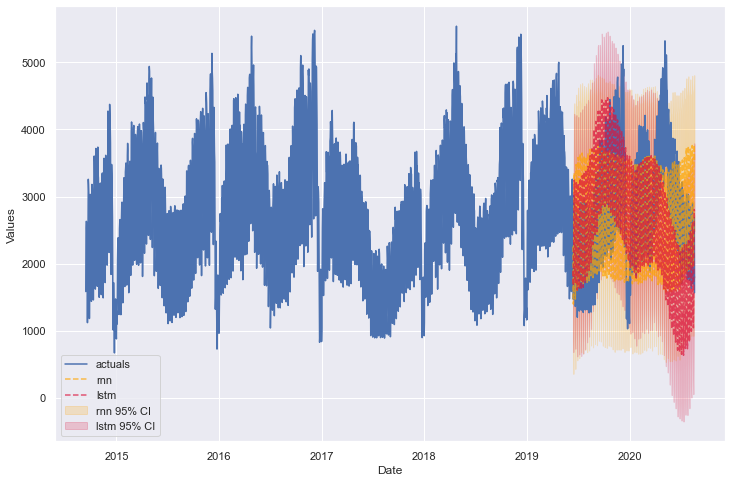

In [53]:
f.plot_test_set(models=['rnn','lstm'],order_by='TestSetMAPE',ci=True)
plt.show()

It doesn't appear as though either of these models outperformed the others, but perhaps they could if we spent more time with them. Recurrent neural nets are most effective in scalecast on datasets with irregular patterns. If the cycles in the series can be represented with variables or Fourier transformed series, then it is more time-effective to apply a simpler model.

### HWES  
- Because this model can only capture one type of seasonality, there is reason to believe it won't perform well in this example  
- Dig deeper into Holt-Winters Exponential Smoothing forecasting with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/hwes/hwes.html)  

In [54]:
f.set_estimator('hwes')
f.tune() # like arima, tuning with validation data is sometimes better than cross validation
f.auto_forecast()

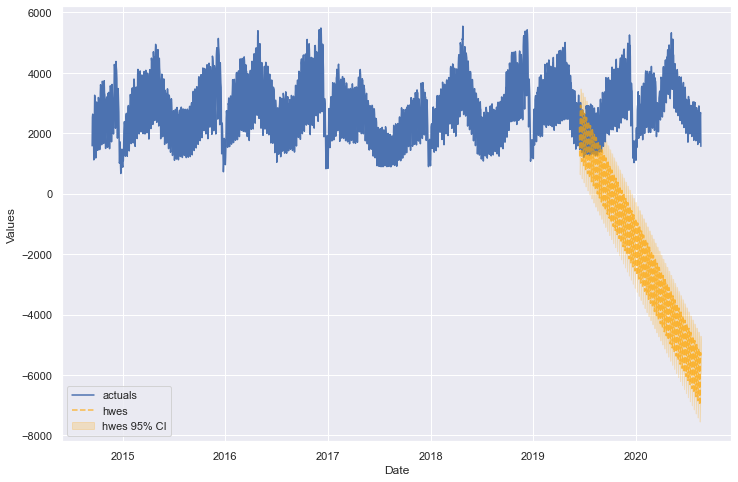

In [55]:
f.plot_test_set(models='hwes',order_by='TestSetMAPE',ci=True)
plt.show()

Very bad!! Like ARIMA, HWES works better when there is only one type of seasonality in the data.

### Theta
- This is was one of the top-performing models in the M4 contest and it extraordinarily simple for how powerful it is
- Dig deeper into Theta forecasting with [this notebook](https://scalecast-examples.readthedocs.io/en/latest/theta/theta.html)

In [56]:
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
theta_grid = {
    'theta':[0.5,1,1.5,2,2.5,3],
    'model_mode':[
        ModelMode.ADDITIVE,
        ModelMode.MULTIPLICATIVE
    ],
    'season_mode':[
        SeasonalityMode.MULTIPLICATIVE,
        SeasonalityMode.ADDITIVE
    ],
    'trend_mode':[
        TrendMode.EXPONENTIAL,
        TrendMode.LINEAR
    ],
}

In [57]:
f.set_estimator('theta')
f.ingest_grid(theta_grid)
f.cross_validate(k=3)
f.auto_forecast()

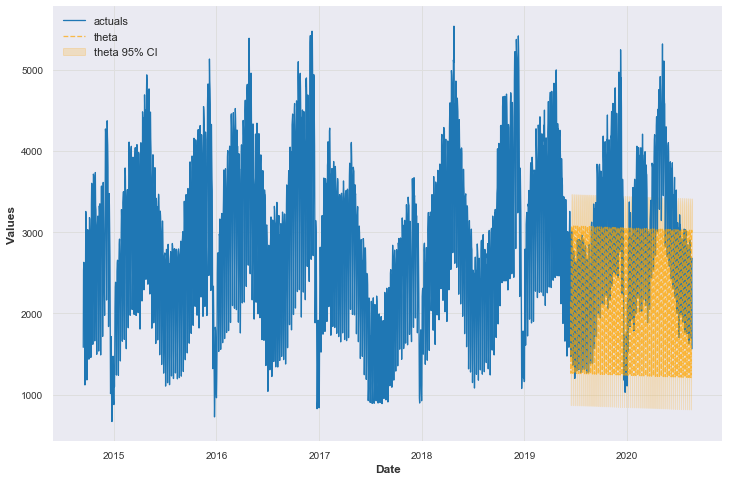

In [68]:
f.plot_test_set(models='theta',order_by='TestSetMAPE',ci=True)
plt.show()

Theta works really well for many time series, but doesn't look like it did too well for this particular one.

## Model Benchmarking

In [58]:
results = f.export('model_summaries',determine_best_by='TestSetMAPE')
results[['ModelNickname','TestSetMAPE','TestSetR2','InSampleMAPE','InSampleR2','best_model']]

,ModelNickname,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2,best_model
0,xgboost,0.114121,0.758769,0.005687,0.999593,True
1,mlr,0.119815,0.800517,0.061176,0.954452,False
2,prophet,0.128508,0.756013,0.098131,0.887426,False
3,avg,0.146941,0.675437,0.057269,0.960752,False
4,rnn,0.230976,0.277627,0.136363,0.754691,False
5,arima,0.248641,0.158171,0.090015,0.898082,False
6,theta,0.251044,-0.075120,0.078664,0.933170,False
7,lstm,0.280238,-0.144925,0.159646,0.715094,False
8,silverkite,0.383909,-0.711844,0.119990,0.839140,False
9,hwes,1.632305,-35.529352,0.080994,0.929713,False


## Backtesting
- The prophet model looks like the best one, but is it really the best? Let's try backtesting our best three models to see which one comes through. Backtesting is the process of testing each model on the last 10 (or however many you specify) forecast horizons to see how that model actually would have performed on average had it been implemented. In our case, we are using a forecast horizon of 60 periods.
- We place 15 observations between each successive training set so that we have minimal overlap in the backtest predictions (we don't want to see how the model does predicting the same values too many times, but we also don't want to not have any overlap because some training sets will be too small to get a reliable sense of)

In [59]:
f.backtest('xgboost',jump_back=15)
f.export_backtest_metrics('xgboost')

,iter1,iter2,iter3,iter4,iter5,iter6,iter7,iter8,iter9,iter10,mean
RMSE,321.243049,256.96461,264.040493,352.183418,501.793258,636.361222,1252.643886,577.233368,501.86931,527.392733,519.172535
MAE,234.12298,202.220553,212.6455,292.41853,409.931093,546.684851,1175.715059,460.884416,380.549622,359.97714,427.514974
R2,0.568692,0.765393,0.790546,0.766566,0.527011,0.038655,-2.472735,0.463572,0.486015,0.377904,0.231162
MAPE,0.096183,0.071947,0.073006,0.09595,0.112154,0.146735,0.298019,0.141357,0.123654,0.121297,0.128030


In [63]:
f.backtest('mlr',jump_back=15)
f.export_backtest_metrics('mlr')

,iter1,iter2,iter3,iter4,iter5,iter6,iter7,iter8,iter9,iter10,mean
RMSE,379.58502,284.854776,303.167,300.607979,453.991446,479.462242,627.282307,437.930844,384.373797,365.183998,401.643941
MAE,283.819377,239.916312,249.936718,244.258842,392.63459,415.822731,571.408435,325.830785,261.20797,234.320938,321.915670
R2,0.397803,0.711702,0.723871,0.82993,0.612835,0.454266,0.129152,0.691241,0.698507,0.701728,0.595104
MAPE,0.116832,0.09263,0.09263,0.081808,0.111679,0.109402,0.149834,0.101724,0.087998,0.081147,0.102569


In [64]:
f.backtest('prophet',jump_back=15)
f.export_backtest_metrics('prophet')

,iter1,iter2,iter3,iter4,iter5,iter6,iter7,iter8,iter9,iter10,mean
RMSE,412.473953,463.534865,584.443779,718.500093,701.755667,635.852484,551.509772,434.385388,387.815372,382.348865,527.262024
MAE,323.067359,387.776258,526.046717,679.821409,643.998604,544.032799,442.619812,318.226392,267.535835,267.79686,440.092205
R2,0.288929,0.236588,-0.026203,0.028416,0.074933,0.040191,0.326833,0.69622,0.693084,0.67303,0.303202
MAPE,0.13997,0.151747,0.188858,0.214673,0.182344,0.144477,0.114737,0.098986,0.09166,0.092193,0.141964


It would appear from this comparison that the univariate MLR is actually the best. Let's see it plotted into the future.

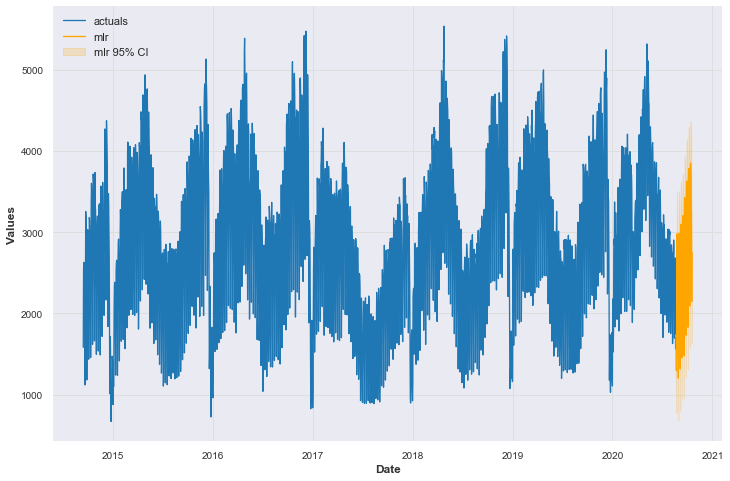

In [65]:
f.plot('mlr',ci=True)
plt.show()

Looks good! Export its forecasts and save them to Excel by using this code.

In [70]:
dfs = f.export(
    dfs = ['model_summaries', 'lvl_test_set_predictions', 'lvl_fcsts'],
    to_excel = True,
    excel_name = 'my forecasts.xlsx',
    models = ['mlr','xgboost','prophet'],
) # this returns a dictionary of dataframes and saves results to excel